In [14]:
import os
import time
import csv
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from facenet_pytorch import InceptionResnetV1

In [15]:
# =========================
# CONFIG
# =========================
YOLO_MODEL_PATH = "yolov8n-face.pt"
KNOWN_FACES_DIR = "known_faces"
CSV_OUTPUT = "face_time_report.csv"

RECOGNITION_THRESHOLD = 0.9
DISAPPEAR_TIMEOUT = 3  # seconds

In [16]:
# =========================
# DEVICE
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [17]:
# =========================
# LOAD MODELS
# =========================
yolo = YOLO(YOLO_MODEL_PATH)
facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

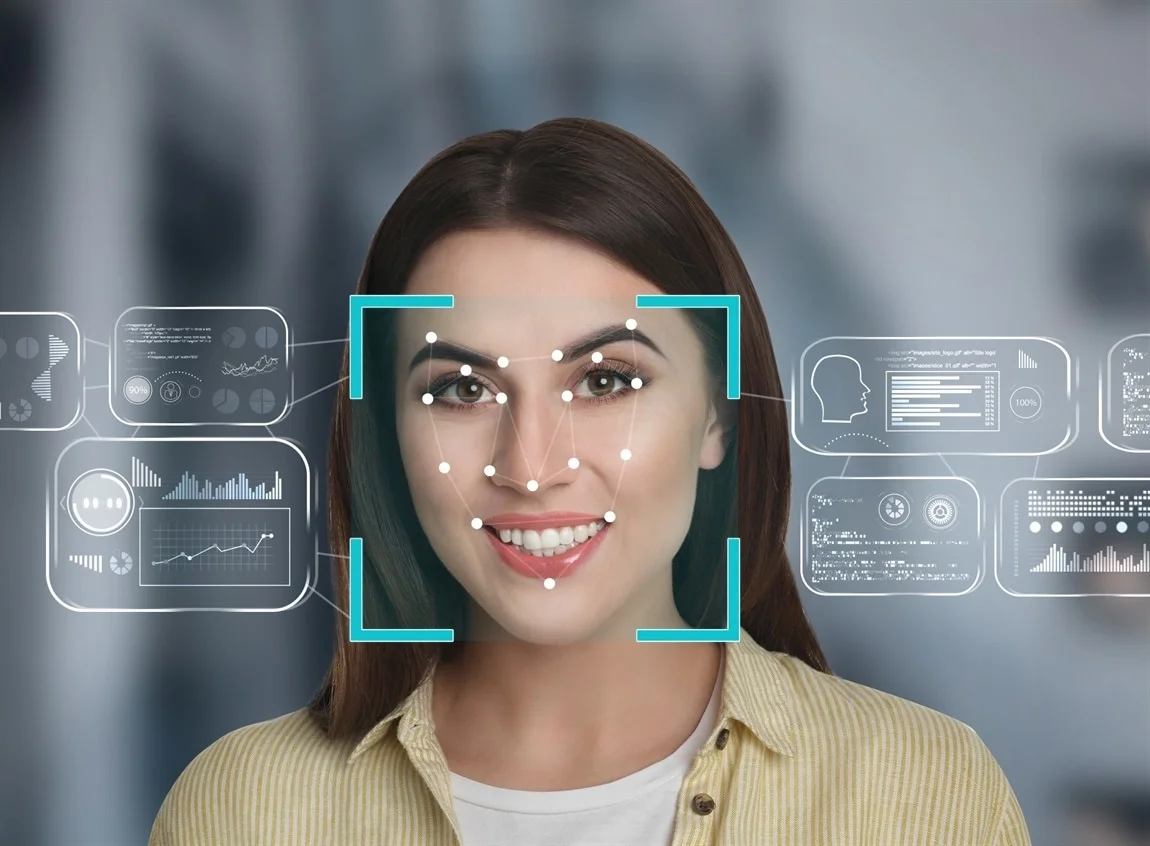

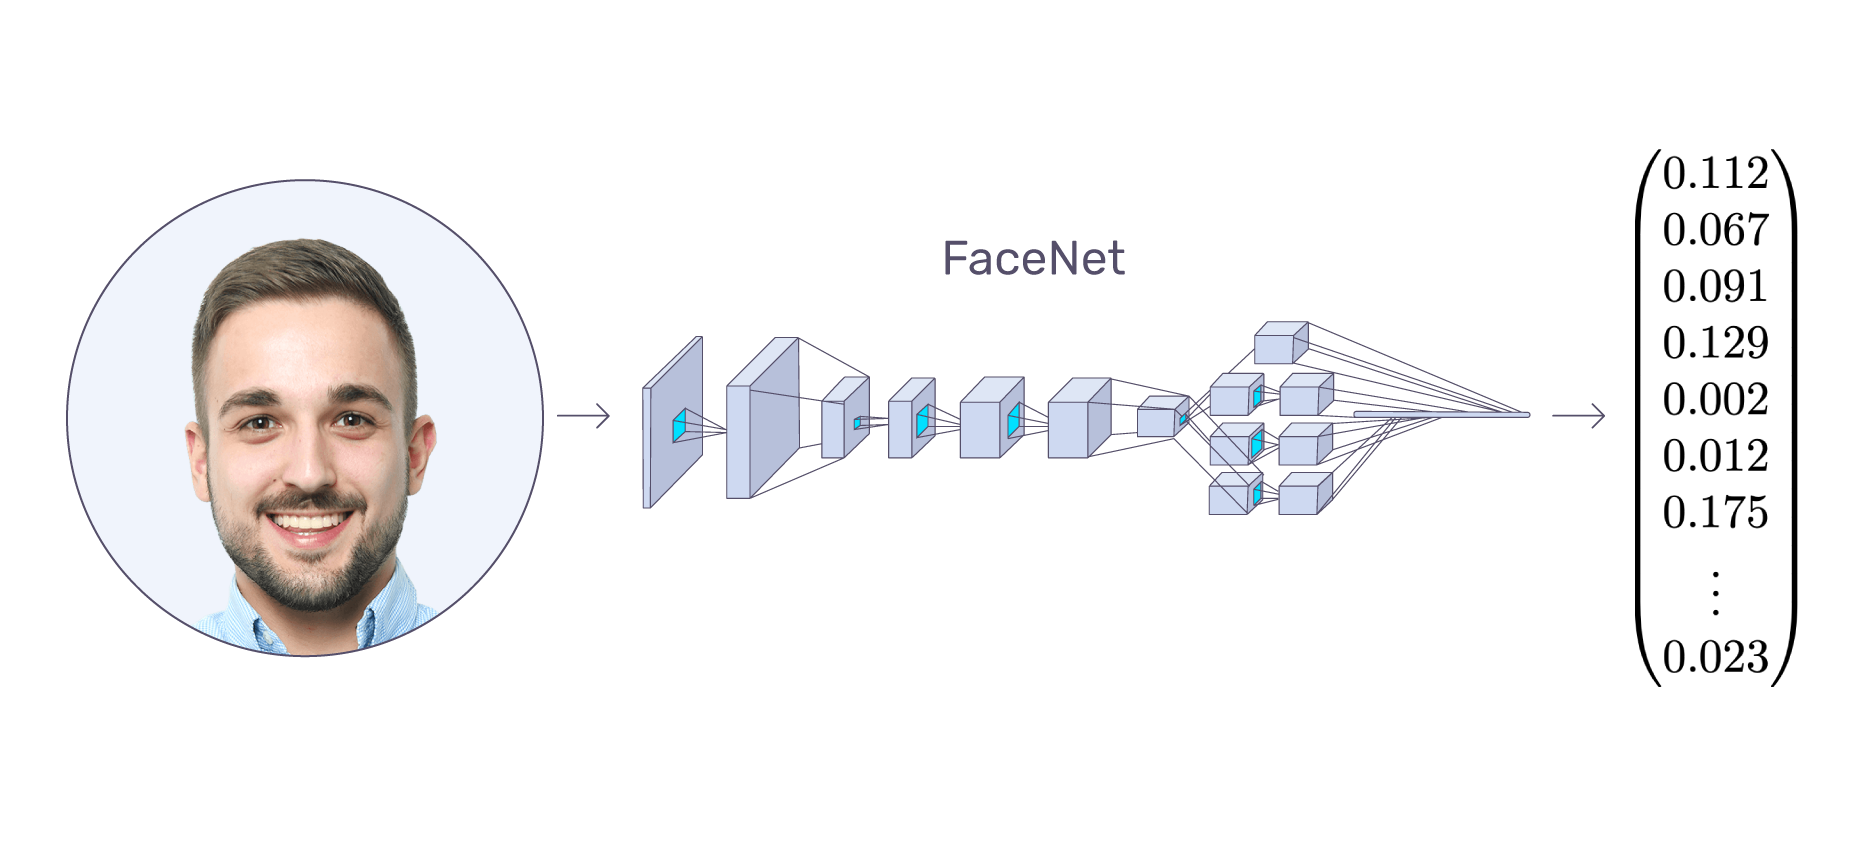

In [18]:
# =========================
# FACE EMBEDDING FUNCTION
# =========================
def get_face_embedding(face_img):
    face_img = cv2.resize(face_img, (160, 160))
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    face_tensor = torch.tensor(face_img).permute(2, 0, 1).float() / 255.0   #   Converts the image from a NumPy array to a PyTorch tensor
    face_tensor = face_tensor.unsqueeze(0).to(device)                       #   add batch dimension -> (1, C, H, W), move to CPU or GPU

    with torch.no_grad():
        embedding = facenet(face_tensor)

    return embedding.cpu().numpy()[0]

In [19]:
# =========================
# LOAD KNOWN FACES
# =========================
known_embeddings = []
known_names = []

for person in os.listdir(KNOWN_FACES_DIR):
    person_dir = os.path.join(KNOWN_FACES_DIR, person)
    if not os.path.isdir(person_dir):
        continue

    for img_name in os.listdir(person_dir):
        img_path = os.path.join(person_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        emb = get_face_embedding(img)
        known_embeddings.append(emb)
        known_names.append(person)

known_embeddings = np.array(known_embeddings)
print(f"Loaded {len(known_embeddings)} known faces")

Loaded 10 known faces


In [20]:
# =========================
# PERSON TIME TRACKER
# =========================
person_tracker = {}

# =========================
# WEBCAM OR VIDEO
# =========================
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise RuntimeError("Could not open webcam")

print("Press ESC to stop")

# =========================
# MAIN LOOP
# =========================
while True:
    ret, frame = cap.read()
    if not ret:
        break

    current_time = time.time()
    detected_names = set()

    results = yolo(frame, conf=0.5, verbose=False)

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            face_crop = frame[y1:y2, x1:x2]

            if face_crop.size == 0:
                continue

            emb = get_face_embedding(face_crop)

            distances = np.linalg.norm(known_embeddings - emb, axis=1)
            min_dist = distances.min()

            if min_dist < RECOGNITION_THRESHOLD:
                name = known_names[distances.argmin()]
            else:
                name = "Unknown"

            detected_names.add(name)

            # =========================
            # TRACK TIME
            # =========================
            if name != "Unknown":
                if name not in person_tracker:
                    person_tracker[name] = {
                        "start_time": current_time,
                        "last_seen": current_time,
                        "total_time": 0.0
                    }
                else:
                    if person_tracker[name]["start_time"] is None:
                        person_tracker[name]["start_time"] = current_time
                    person_tracker[name]["last_seen"] = current_time

            # =========================
            # DRAW
            # =========================
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, name, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # =========================
    # HANDLE DISAPPEARED
    # =========================
    for name, data in person_tracker.items():
        if data["start_time"] is not None:
            if current_time - data["last_seen"] > DISAPPEAR_TIMEOUT:
                session_time = data["last_seen"] - data["start_time"]
                data["total_time"] += session_time
                data["start_time"] = None

    cv2.imshow("Face Recognition & Time Tracking", frame)

    if cv2.waitKey(1) & 0xFF == 27:
        break

# =========================
# FINALIZE OPEN SESSIONS
# =========================
end_time = time.time()
for name, data in person_tracker.items():
    if data["start_time"] is not None:
        data["total_time"] += end_time - data["start_time"]

# =========================
# SAVE CSV
# =========================
with open(CSV_OUTPUT, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Name", "Total Time (Seconds)", "Total Time (Minutes)"])

    for name, data in person_tracker.items():
        sec = round(data["total_time"], 2)
        writer.writerow([name, sec, round(sec / 60, 2)])

print("Saved:", CSV_OUTPUT)

cap.release()
cv2.destroyAllWindows()


Press ESC to stop
Saved: face_time_report.csv
